WHO-COVID-19-global-daily-data

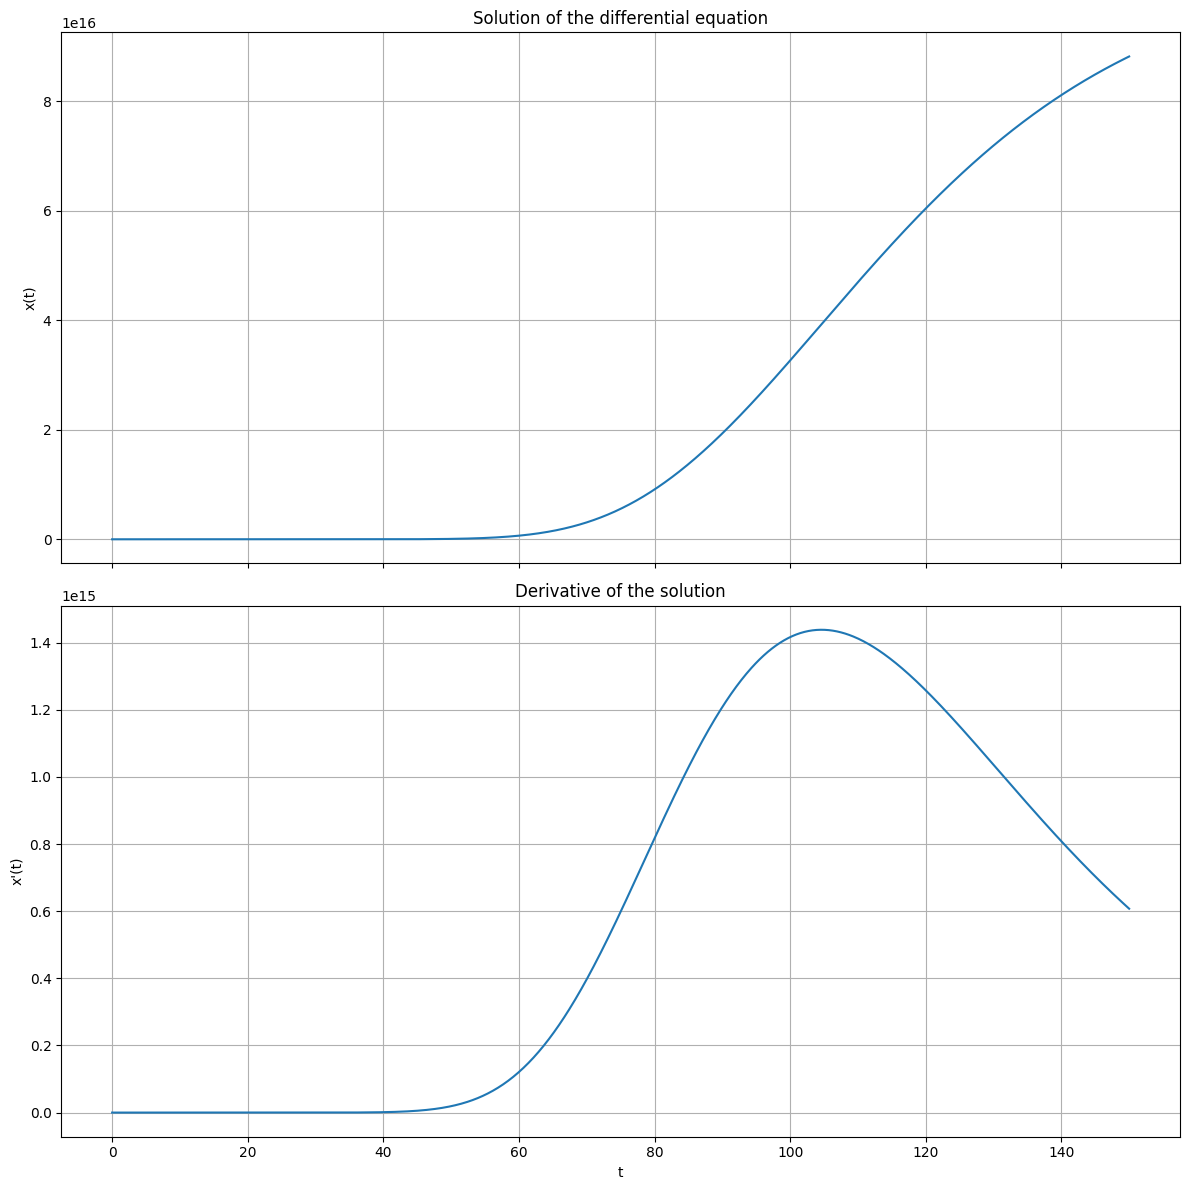

In [49]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# define the model
def model(x, t, a, b, c):
    dxdt = a * x + b * x ** (1 + c)
    return dxdt

# parameters
a = 3.7
b = -2.5
c = 0.01

# initial condition
x0 = 1.0

# time points
t = np.linspace(0, 150, 1000)

# solve ODE
x = odeint(model, x0, t, args=(a, b, c))

# compute derivative of solution
dxdt = a * x + b * x ** (1 + c)

# create two subplots that share the same x-axis
fig, axs = plt.subplots(2, 1, figsize=(12, 12), sharex=True)

# plot the solution on the first subplot
axs[0].plot(t, x)
axs[0].set_ylabel('x(t)')
axs[0].set_title('Solution of the differential equation')
axs[0].grid()

# plot the derivative on the second subplot
axs[1].plot(t, dxdt)
axs[1].set_xlabel('t')
axs[1].set_ylabel("x'(t)")
axs[1].set_title("Derivative of the solution")
axs[1].grid()

# layout so plots do not overlap
fig.tight_layout()

plt.show()

In [4]:
import pandas as pd

df= pd.read_csv('WHO-COVID-19-global-daily-data.csv')


In [5]:
start_date = '2020-02-15'
end_date = '2020-07-15'

italy_df = df[(df['Country'] == 'Italy') & 
              (df['Date_reported'] >= start_date) & 
              (df['Date_reported'] <= end_date)]

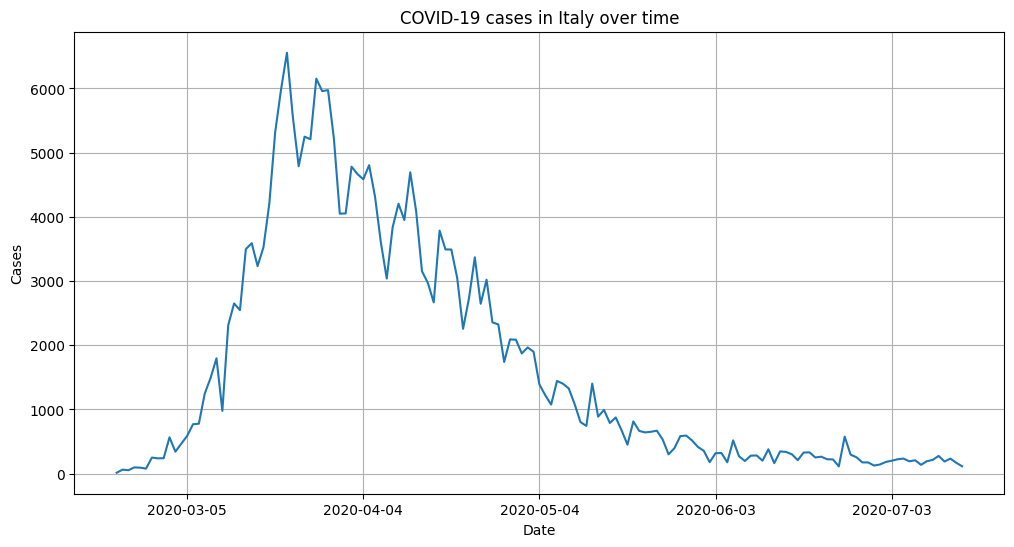

In [6]:
# Assuming 'date' is in datetime format, you can plot the data as follows:
import matplotlib.dates as mdates


plt.figure(figsize=(12,6))
plt.plot(italy_df['Date_reported'], italy_df['New_cases'])  # Replace 'cases' with the actual column name
plt.xlabel('Date')
plt.ylabel('Cases')
plt.title('COVID-19 cases in Italy over time')
plt.grid()
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))

plt.show()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     173.6
Date:                Sun, 05 Jan 2025   Prob (F-statistic):           0.000945
Time:                        17:37:20   Log-Likelihood:                -6.2030
No. Observations:                   5   AIC:                             16.41
Df Residuals:                       3   BIC:                             15.62
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.5000      1.133     -3.090      0.0

C:\Users\leocr\Projects\Economics\.venv\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
